In [46]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tensorboard
import tqdm

In [47]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

### MNIST Data 

In [48]:
BATCH_SIZE = 64
NUM_WORKERS = 4

In [49]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [50]:
data = torchvision.datasets.MNIST(root="./data", train=True, transform=data_transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [51]:
num_batches = len(data_loader)

#### Visualize MNIST Digits

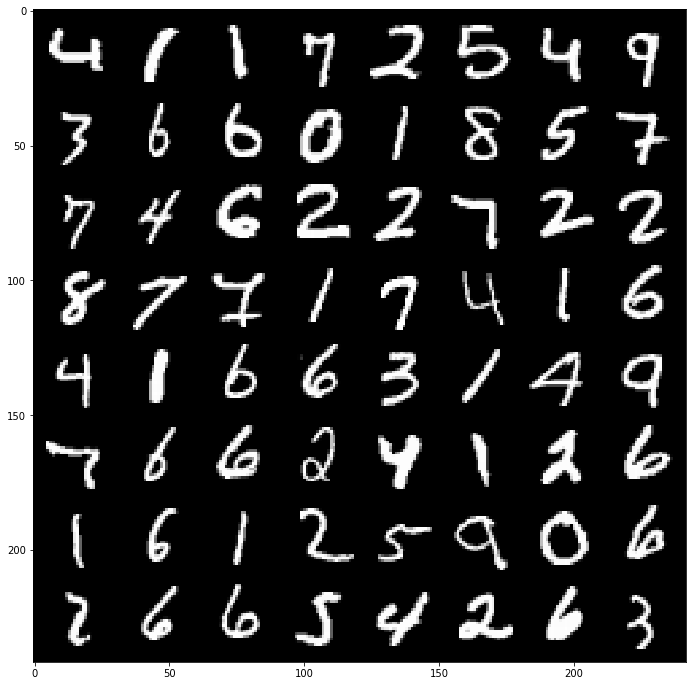

In [52]:
x, y = next(iter(data_loader))
grid = torchvision.utils.make_grid(x, nrow=8)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.show()

In [53]:
print(x.shape, y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Model

#### 1. Discriminator Model

In [54]:
class Discriminator(torch.nn.Module):
    
    def __init__(self, in_features=784, n_out=1, hidden_dims=[1024, 512, 256]):
        super(Discriminator, self).__init__()
        
        modules  = []
        
        # hidden dims
        if hidden_dims is None:
            hidden_dims = [1024, 512, 256]
            
        # create hidden layers
        for h_dim in hidden_dims:
            modules.append(self.nn_layer(in_features=in_features, out_features=h_dim))
            in_features = h_dim
        
        # output layer with sigmoid activation
        modules.append(nn.Sequential(
            nn.Linear(in_features=in_features, out_features=n_out),
            nn.Sigmoid()
        ))
        
        self.out = nn.Sequential(*modules)
        
        
    def nn_layer(self, in_features, out_features):
        layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        return layer

    def forward(self, x):
        out = self.out(x)
        return out

In [58]:
class Generator(torch.nn.Module):

    def __init__(self, in_features=100, out_features=784, hidden_dims=[256, 512, 1024]):
        super(Generator, self).__init__()
        
        # noise_dim is in_features 
    
        if hidden_dims is None:
            hidden_dims=[256, 512, 1024]
            
        modules = []
        
        for h_dim in hidden_dims:
            modules.append(self.nn_layer(in_features=in_features, out_features=h_dim))
            in_features = h_dim
            
        modules.append(nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.Tanh()
        ))
        
        self.out = nn.Sequential(*modules)
        
    def nn_layer(self, in_features, out_features):
        layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.LeakyReLU(0.2)
        )
        return layer
        

    def forward(self, x):
        out = self.out(x)
        return out


### Training

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = tensorboard.SummaryWriter()

In [70]:
lr = 0.0003
epochs = 100
noise_dim = 100

In [71]:
## Create models
gen = Generator().to(device)
disc = Discriminator().to(device)

In [72]:
criterion = nn.BCELoss().to(device)
d_optimizer = torch.optim.Adam(disc.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)

Step: 100%|█████████▉| 936/938 [00:49<00:00, 22.08it/s]

In [73]:
steps = 0
epoch_progress = tqdm.tqdm(total=epochs, desc="Epoch", position=0)

for epoch in range(epochs):
    g_epoch_loss = []
    d_epoch_loss = []
    step_progress = tqdm.tqdm(total=num_batches, desc="Step", position=0)
    
    for i, (images, _) in enumerate(data_loader):
        
        batch, channel, h, w = images.size(0), images.size(1), images.size(2), images.size(3)
        
        images = images.view(-1, channel*h*w).to(device)
        gt_real = torch.ones((batch, 1), device=device)
        
        """
        -- TRAIN DISCRIMINATOR --
        """
        d_optimizer.zero_grad()
        # Train on real data
        d_loss_real = criterion(disc(images), gt_real)
        d_loss_real.backward()
        # train on fake data
        # create fake data from gaussian noise
        noise = torch.randn((batch, noise_dim), device=device)
        gt_fake = torch.zeros((batch, 1), device=device)
        d_loss_fake = criterion(disc(gen(noise)), gt_fake)
        d_loss_fake.backward()
        
        # update the params
        d_optimizer.step()
        
        d_loss = d_loss_real + d_loss_fake
        
        """
        -- TRAIN GENERATOR --
        """
        g_optimizer.zero_grad()
        g_loss = criterion(disc(gen(noise)), gt_real) # noise train as real image
        g_loss.backward()
        g_optimizer.step()
        
        writer.add_scalar("step_wise_loss", d_loss.item(), steps)
        writer.add_scalar("step_wise_loss", g_loss.item(), steps)
        g_epoch_loss.append(g_loss.item())
        d_epoch_loss.append(d_loss.item())
        
        if steps%5000==0:
            print(f'epoch {epoch} |  step  {steps} | d_loss {d_loss.item()} | g_loss {g_loss.item()}')
    
        step_progress.update(1)
        steps += 1
        
    g_loss_avg = sum(g_epoch_loss)/len(g_epoch_loss)
    d_loss_avg = sum(d_epoch_loss)/len(d_epoch_loss)
    
    writer.add_scalar("epoch_wise_loss", g_loss_avg, epoch)
    writer.add_scalar("epoch_wise_loss", d_loss_avg, epoch)
    epoch_progress.update(1)

Step:   1%|          | 5/938 [00:00<01:00, 15.44it/s]

epoch 0 |  step  0 | d_loss 1.39686918258667 | g_loss 0.7280533313751221


Step:  34%|███▎      | 316/938 [00:12<00:27, 22.55it/s] 

epoch 5 |  step  5000 | d_loss 1.1108969449996948 | g_loss 1.825584888458252


Step:  67%|██████▋   | 625/938 [00:24<00:12, 24.82it/s]

epoch 10 |  step  10000 | d_loss 0.5064196586608887 | g_loss 1.7891119718551636


Step: 100%|█████████▉| 934/938 [00:37<00:00, 25.54it/s]

epoch 15 |  step  15000 | d_loss 0.6235991716384888 | g_loss 3.147066116333008


Step:  33%|███▎      | 307/938 [00:12<00:24, 25.38it/s]

epoch 21 |  step  20000 | d_loss 0.816655158996582 | g_loss 1.828172206878662


Step:  66%|██████▌   | 615/938 [00:27<00:14, 22.83it/s]

epoch 26 |  step  25000 | d_loss 1.167340636253357 | g_loss 2.020320415496826


Step:  99%|█████████▊| 925/938 [00:44<00:00, 14.78it/s]

epoch 31 |  step  30000 | d_loss 0.5045021772384644 | g_loss 2.1074342727661133


Step:  32%|███▏      | 297/938 [00:13<00:30, 20.99it/s]

epoch 37 |  step  35000 | d_loss 0.5185412764549255 | g_loss 3.7087910175323486


Step:  65%|██████▍   | 607/938 [00:33<00:20, 16.46it/s]

epoch 42 |  step  40000 | d_loss 0.6276625394821167 | g_loss 2.220449686050415


Step:  98%|█████████▊| 917/938 [00:39<00:01, 19.59it/s]

epoch 47 |  step  45000 | d_loss 0.43490731716156006 | g_loss 1.9939409494400024


Step:  31%|███       | 291/938 [00:10<00:22, 28.20it/s]

epoch 53 |  step  50000 | d_loss 0.516788125038147 | g_loss 2.9438328742980957


Step:  64%|██████▍   | 601/938 [00:34<00:13, 24.51it/s]

epoch 58 |  step  55000 | d_loss 0.677204966545105 | g_loss 2.088684558868408


Step:  97%|█████████▋| 910/938 [00:34<00:01, 26.59it/s]

epoch 63 |  step  60000 | d_loss 0.6085101962089539 | g_loss 3.6483681201934814


Step:  30%|███       | 282/938 [00:12<00:32, 20.38it/s]

epoch 69 |  step  65000 | d_loss 0.3501152992248535 | g_loss 3.606964588165283


Step:  63%|██████▎   | 593/938 [00:27<00:14, 24.26it/s]

epoch 74 |  step  70000 | d_loss 0.559038519859314 | g_loss 3.5148210525512695


Step:  96%|█████████▋| 903/938 [00:49<00:01, 23.07it/s]

epoch 79 |  step  75000 | d_loss 0.4314274787902832 | g_loss 4.849875450134277


Step:  29%|██▉       | 273/938 [00:15<00:33, 19.90it/s]t]

epoch 85 |  step  80000 | d_loss 0.46567481756210327 | g_loss 3.6981945037841797


Step:  62%|██████▏   | 584/938 [00:32<00:19, 17.83it/s]t]

epoch 90 |  step  85000 | d_loss 0.2274802029132843 | g_loss 3.7563960552215576


Step:  95%|█████████▌| 893/938 [00:38<00:02, 15.92it/s]t]

epoch 95 |  step  90000 | d_loss 0.1932884156703949 | g_loss 3.552668809890747


Step: 100%|██████████| 938/938 [00:53<00:00, 25.95it/s]it]

### Test the Generator Network

In [81]:
gen.eval()
noise = torch.randn((BATCH_SIZE, noise_dim))
data = gen(noise).view(-1, 1, 28, 28)

In [82]:
data.size()

torch.Size([64, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


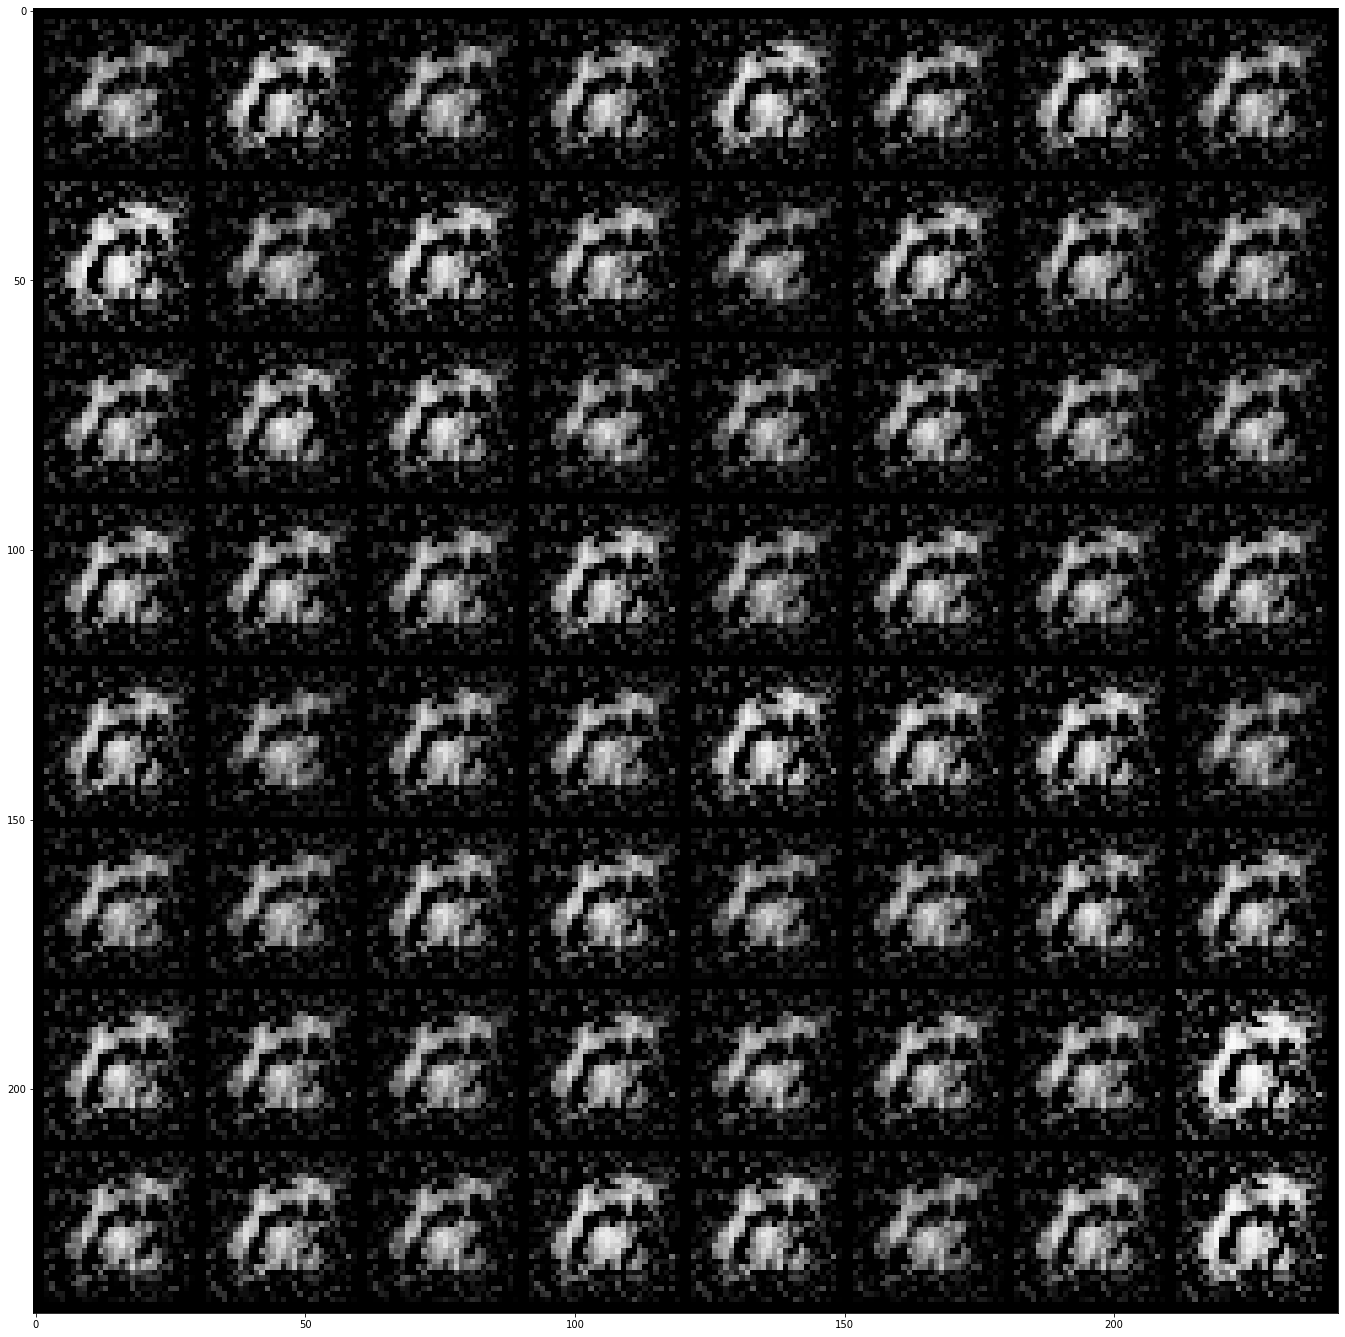

In [85]:
grid = torchvision.utils.make_grid(data, nrow=8)
plt.figure(figsize=(24, 24))
plt.imshow(grid.detach().cpu().permute(1, 2, 0), cmap="gray")

#### Don't know, why it does progress towards Nash Equilibiium Posssible Fix
- More training
- Add more layers
- Standardrize the pixel values between [-1, 1]
- Learning rate and Optimizer
- Try changing the activation functions of the Generator Network, replace the LeakyRelu with Tanh